In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path.append("/home/jellouli/dataset-distillation/external/DeepInversion/cifar10")

In [4]:
TEACHER_WEIGHTS_PATH = "/home/jellouli/dataset-distillation/model_weights/final_state_resnet.tar"

In [5]:
CIFAR10_PATH = '/mlodata1/jellouli'

In [6]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
from resnet_cifar import ResNet18
import collections
import random
import tqdm

# Model training
- Resnet18
- Check that training was successful
- validate loss on cifar10 datase

In [10]:
model = ResNet18()

In [11]:
training_state = torch.load(TEACHER_WEIGHTS_PATH)

In [12]:
training_state.keys()

dict_keys(['train_losses', 'test_losses', 'test_accs', 'best_acc', 'best_model'])

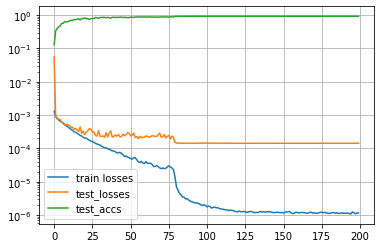

In [13]:
plt.plot(training_state['train_losses'],label='train losses')
plt.plot(training_state['test_losses'], label='test_losses')
plt.plot(training_state['test_accs'], label='test_accs')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [14]:
print(training_state['best_acc'])

tensor(0.9265, device='cuda:0')


In [15]:
model.load_state_dict(training_state['best_model'])

<All keys matched successfully>

In [24]:
test_transform = T.Compose(
        [T.ToTensor()]) #, T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
eval_set = CIFAR10(CIFAR10_PATH, train=False , transform=test_transform)

In [35]:
model.eval()
model.cuda()
with torch.no_grad():
    num_correct = 0
    for images, labels in DataLoader(eval_set,batch_size=4096):
        result = model(images.cuda())
        pred = result.argmax(1)
        num_correct += (pred == labels.cuda()).sum()
    print(float(num_correct / len(eval_set)))

0.9259999990463257


# DeepInversion
- Apply deep inversion to the above model in order to generate images

In [15]:
from deepinversion_cifar10 import get_images

Please install apex from https://www.github.com/nvidia/apex to run this example.
will attempt to run without it


In [37]:
class DeepInversionFeatureHook:
    """
    Implementation of the forward hook to track feature statistics and compute a loss on them.
    Will compute mean and variance, and will use l2 as a loss
    """

    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # hook co compute deepinversion's feature distribution regularization
        nch = input[0].shape[1]
        
        mean = input[0].mean([0, 2, 3])
        var = (
            input[0]
            .permute(1, 0, 2, 3)
            .contiguous()
            .view([nch, -1])
            .var(1, unbiased=False)
        )

        # forcing mean and variance to match between two distributions
        # other ways might work better, e.g. KL divergence
        r_feature = torch.norm(
            module.running_var.data.type(var.type()) - var, 2
        ) + torch.norm(module.running_mean.data.type(var.type()) - mean, 2)

        self.r_feature = r_feature
        # must have no output

    def close(self):
        self.hook.remove()

In [9]:
5e-5 == 0.00005

True

In [38]:
def get_images(
    net,
    bs=256,
    epochs=1000,
    l2_coeff=0.0,
    var_scale=0.00005,
    bn_reg_scale=0.0,
    optimizer=None,
    student_net=None,
    inputs=None,
):
    best_cost = 1e6
    net.eval()
    
    # initialize gaussian inputs
    inputs.data = torch.randn((bs, 3, 32, 32), requires_grad=True, device="cuda")
    
    if student_net:
        optimizer_student = torch.optim.SGD(student_net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        criterion_student = nn.CrossEntropyLoss()
        
    # set up criteria for optimization
    criterion = nn.CrossEntropyLoss()

    optimizer.state = collections.defaultdict(dict)  # Reset state of optimizer

    # target outputs to generate
    targets = torch.LongTensor([random.randint(0, 9) for _ in range(bs)]).to("cuda")
    
    # Create hooks for feature statistics catching
    loss_r_feature_layers = []
    for module in net.modules():
        if isinstance(module, nn.BatchNorm2d):
            loss_r_feature_layers.append(DeepInversionFeatureHook(module))

    # setting up the range for jitter
    lim_0, lim_1 = 2, 2

    for epoch in tqdm.tqdm(range(epochs)):
        # apply random jitter offsets
        off1 = random.randint(-lim_0, lim_0)
        off2 = random.randint(-lim_1, lim_1)
        inputs_jit = torch.roll(inputs, shifts=(off1, off2), dims=(2, 3))

        # foward with jit images
        optimizer.zero_grad()
        outputs = net(inputs_jit)
        loss = criterion(outputs, targets)
        loss_target = loss.item()
        
        if student_net:
            optimizer_student.zero_grad()
            loss_student = criterion_student(student_net(inputs_jit), targets)
            loss_student.backward()
            optimizer_student.step()

        # apply total variation regularization
        diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
        diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
        diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
        diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]
        loss_var = (
            torch.norm(diff1)
            + torch.norm(diff2)
            + torch.norm(diff3)
            + torch.norm(diff4)
        )
        loss = loss + var_scale * loss_var

        # R_feature loss
        loss_distr = sum([mod.r_feature for mod in loss_r_feature_layers])
        loss = loss + bn_reg_scale * loss_distr  # best for noise before BN

        loss = loss + l2_coeff * torch.norm(inputs_jit, 2)

        if best_cost > loss.item():
            best_cost = loss.item()
            best_inputs = inputs.data
        loss.backward()
        optimizer.step()

    return best_inputs, targets, student_net

In [73]:
bs = 256
lr = 0.05
l2_scale = 0
var_scale = 2.5e-5

In [74]:
inputs = torch.randn((bs, 3, 32, 32), requires_grad=True, device='cuda')
optimizer_di = torch.optim.Adam([inputs], lr=lr)

In [75]:
images, targets, student_net = get_images(model, 
                   bs=256,
                   epochs=2000,
                   var_scale=var_scale,
                   optimizer = optimizer_di,
                   inputs = inputs,
                   bn_reg_scale=100,
                   student_net=ResNet18().cuda(),
                   l2_coeff=l2_scale)

100%|██████████| 2000/2000 [23:11<00:00,  1.44it/s]


In [39]:
images = torch.load('images.tar')

In [40]:
labels = torch.load('labels.tar')

In [52]:
labels[10]

tensor(5)

In [60]:
class CIFAR10Transform:
    data_mean = (0.4914, 0.4822, 0.4465)
    data_stddev = (0.2023, 0.1994, 0.2010)

In [63]:
import numpy as np 

In [114]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
#     image = (image - image.min()) / (image.max() - image.min())
    image = image.transpose(1, 2, 0)
    image = (image + np.array(CIFAR10Transform.data_mean)) * np.array(CIFAR10Transform.data_stddev)
#     image = (image - image.min()) / (image.max() - image.min())
    
#     image = image.clip(0, 1)*255
    return image

In [120]:
labels[120]

tensor(9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


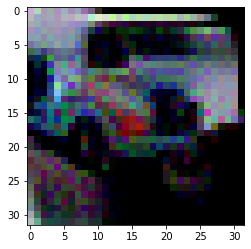

In [119]:
plt.imshow(im_convert(images[120]))

- Hasn't converged yet
- or hyper-parameters bad
- training after distillation better

In [44]:
def train_student(model, images, labels, epochs):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    for _ in tqdm.tqdm(range(epochs)):
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    return model

In [63]:
test_model(ResNet18().cuda())

0.11369999498128891


In [64]:
student_model = train_student(ResNet18().cuda(), images, targets, 1000)

100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


In [82]:
torch.save(student_net.state_dict(), 'student.tar')

In [80]:
torch.save(images, 'images.tar')

In [81]:
torch.save(labels, 'labels.tar')

In [16]:
student_net= ResNet18()

In [17]:
student_net.load_state_dict(torch.load('student.tar'))

<All keys matched successfully>

In [21]:
test_model(ResNet18().cuda())

0.09999999403953552


In [19]:
test_model(student_net.eval().cuda())

0.11400000005960464


# Adaptive DeepInversion

In [1]:
from fed_distill.cifar10 import load_cifar10_test

In [2]:
data = load_cifar10_test('/mlodata1/jellouli')

In [3]:
targets = np.array(data.targets)

NameError: name 'np' is not defined

In [4]:
import numpy as np 

In [13]:
from torch.utils.data import Subset

In [15]:
Subset(data, targets.argsort()[:5])

In [6]:
from fed_distill.fed.splitter import HeterogenousDistribution

In [7]:
f = HeterogenousDistribution(data)

In [9]:
a = f.split(10)

In [13]:
len(a[-1])

1000

In [21]:
np.concatenate([[1,2,3], [4,5,6]])

array([1, 2, 3, 4, 5, 6])

In [22]:
%load_ext autoreload
%autoreload 2